## Imports

In [1]:
# File
import pathlib

In [2]:
# Data
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
# Charting
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Deep Learning
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPool2D, Dense, Flatten

Using TensorFlow backend.


## Get Data

In [5]:
# Available files
pathlib.os.listdir('data')

['acc.csv', 'vel.csv', 'exc.csv', 'disp.csv']

In [6]:
print('Reading acc')
acc_raw = np.genfromtxt('./data/acc.csv', delimiter=',')
print('Reading vel')
vel_raw = np.genfromtxt('./data/vel.csv', delimiter=',')
print('Reading exc')
exc_raw = np.genfromtxt('./data/exc.csv', delimiter=',')
print('Reading disp')
disp_raw = np.genfromtxt('./data/disp.csv', delimiter=',')

Reading acc
Reading vel
Reading exc
Reading disp


In [7]:
acc_df = pd.DataFrame(acc_raw.T, columns=['acc','acc_10noise'])
vel_df = pd.DataFrame(vel_raw.T, columns=['vel','vel_10noise'])
exc_df = pd.DataFrame(exc_raw.T, columns=['exc','exc_10noise'])
disp_df = pd.DataFrame(disp_raw.T, columns=['disp','disp_10noise'])

In [8]:
data = pd.concat([acc_df, vel_df, exc_df, disp_df], axis=1)

In [9]:
def plot_stacked_timesseries(data, top_col, bottom_col, quantity, top_y_label, bottom_y_label):
    sns.set(style="ticks", color_codes=True)
    plt.subplot(2, 1, 1)
    plt.plot(data.index, data.loc[:, top_col], '.-')
    plt.title(quantity + ' over Time')
    plt.ylabel(top_y_label)

    plt.subplot(2, 1, 2)
    plt.plot(data.index, data.loc[:, bottom_col], '.-')
    plt.xlabel('time (units)')
    plt.ylabel(bottom_y_label)
    plt.show()

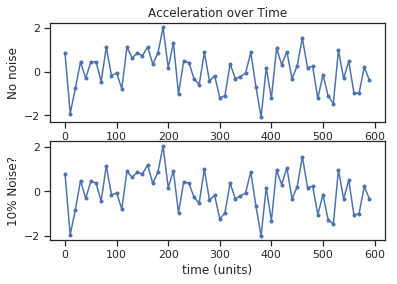

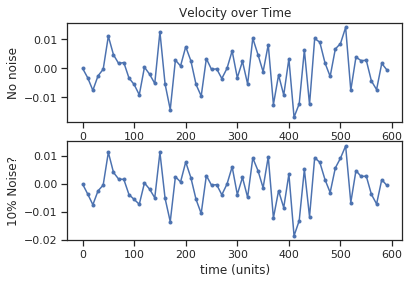

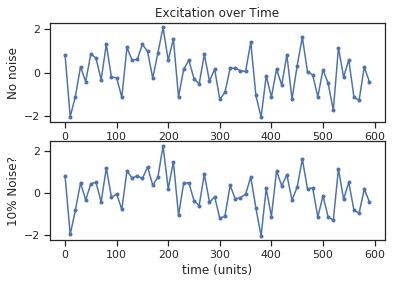

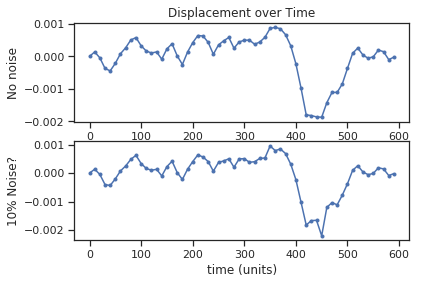

In [10]:
for info in [(acc_df, 'acc', 'acc_10noise', 'Acceleration'), 
             (vel_df, 'vel', 'vel_10noise', 'Velocity'),
             (exc_df, 'exc', 'exc_10noise', 'Excitation'),
             (disp_df, 'disp', 'disp_10noise', 'Displacement')]:
    
    plot_stacked_timesseries(info[0].iloc[:600:10], info[1], info[2],
                             info[3], 'No noise','10% Noise?')

## Preprocessing

In [11]:
no_noise_data = data.loc[:, [x for x in data.columns if 'noise' not in x]]
noise_data = data.loc[:, [x for x in data.columns if 'noise' in x]]

In [12]:
input_scaled = pd.DataFrame()
for col in no_noise_data.columns:
    mean = no_noise_data[col].mean()
    minimum = no_noise_data[col].min()
    maximum = no_noise_data[col].max()
    input_scaled[col] = (no_noise_data[col]-mean)/(maximum - minimum)
    input_scaled[col] = input_scaled[col] / 2.0 + 0.5
    
noise_input_scaled = pd.DataFrame()
for col in noise_data.columns:
    mean = noise_data[col].mean()
    minimum = noise_data[col].min()
    maximum = noise_data[col].max()
    noise_input_scaled[col] = (noise_data[col]-mean)/(maximum - minimum)
    noise_input_scaled[col] = noise_input_scaled[col] / 2.0 + 0.5

In [13]:
input_data_scaled = input_scaled.drop('disp',axis=1)
output_data_scaled = input_scaled['disp']

noise_input_data_scaled = noise_input_scaled.drop('disp_10noise',axis=1)
noise_output_data_scaled = noise_input_scaled['disp_10noise']

In [14]:
input_vals = input_data_scaled.values.reshape(-1,100,3,1)
output_vals = output_data_scaled.values.reshape(-1,100)

noise_input_vals = noise_input_data_scaled.values.reshape(-1,100,3,1)
noise_output_vals = noise_output_data_scaled.values.reshape(-1,100)

## Model

In [15]:
def run_and_results(X_train, X_test, y_train, y_test):
    
    # Model
    model = Sequential()

    # -- INPUT
    model.add(Conv2D(3, (9,3), padding='same', input_shape=X_train[0].shape, activation='relu'))
    # model.add(MaxPool2D(pool_size=(1,2)))

    # -- HIDDEN
    model.add(Conv2D(8, (15,1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.33))


    model.add(Flatten())
    model.add(Dense(500, activation='relu'))

    # -- OUTPUT
    model.add(Dense(100))


    # Prepare model for training
    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mae'])

    # -- SUMMARY
    print(model.summary())
    
    # Fit model
    history = model.fit(X_train, y_train,
                        batch_size=5000,
                        epochs=700,
                        verbose=True,
                        validation_data=(X_test, y_test))
    
    # Scores
    print(model.evaluate(X_test, y_test, verbose=0))
    
    # Error plot (%)
    preds = model.predict(X_test)
    resids = pd.DataFrame(((preds - y_test)/y_test).reshape(-1))  * 100
    resids.plot(kind='hist', bins=100, title='% Residuals Histogram')
    print(resids.describe())
    
    # Prediction plots
    full_preds = pd.DataFrame(model.predict(input_data_scaled.values.reshape(-1,100,3,1)).reshape(-1), columns=['Preds'])
    full_preds = (full_preds - 0.5) * 2.0 * (no_noise_data['disp'].max()-no_noise_data['disp'].min()) + no_noise_data['disp'].mean()

    plt.figure(figsize=(15,6))

    min_index = 0
    max_index = 300
    top = full_preds[min_index:max_index]
    middle = no_noise_data['disp'][min_index:max_index]
    bottom = full_preds[min_index:max_index].subtract(no_noise_data['disp'][min_index:max_index],axis='index')

    sns.set(style="ticks", color_codes=True)

    plt.title('Displacement over Time')

    plt.subplot(3, 1, 1)
    plt.plot(middle.index, middle, '.-')
    plt.ylabel('Actl Disp')

    plt.subplot(3, 1, 2)
    plt.plot(top.index, top, '.-')
    plt.ylabel('Pred Disp')

    plt.subplot(3, 1, 3)
    plt.plot(bottom.index, bottom, '.-')
    plt.ylabel('Residuals')

    plt.xlabel('time (units)')
    plt.show()
    
    results = full_preds.join(no_noise_data['disp'])
    results[:2000].plot(figsize=(15,6))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 3, 3)         84        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 3, 8)          368       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 1, 8)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 43, 1, 8)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 344)               0         
_________________________________________________________________
dense_1 (Dense)      

Epoch 36/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0033 - mean_absolute_error: 0.0457 - val_loss: 0.0020 - val_mean_absolute_error: 0.0359
Epoch 37/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0032 - mean_absolute_error: 0.0451 - val_loss: 0.0020 - val_mean_absolute_error: 0.0356
Epoch 38/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0032 - mean_absolute_error: 0.0450 - val_loss: 0.0020 - val_mean_absolute_error: 0.0357
Epoch 39/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0031 - mean_absolute_error: 0.0447 - val_loss: 0.0020 - val_mean_absolute_error: 0.0352
Epoch 40/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0031 - mean_absolute_error: 0.0442 - val_loss: 0.0020 - val_mean_absolute_error: 0.0351
Epoch 41/700
11620/11620 [==============================] - 0s 7us/step - loss: 0.0030 - mean_absolute_error: 0.0436 - val_loss: 0.0019 - val_mean_abs

Epoch 84/700
11620/11620 [==============================] - 0s 5us/step - loss: 0.0018 - mean_absolute_error: 0.0338 - val_loss: 0.0013 - val_mean_absolute_error: 0.0281
Epoch 85/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0018 - mean_absolute_error: 0.0337 - val_loss: 0.0013 - val_mean_absolute_error: 0.0282
Epoch 86/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0018 - mean_absolute_error: 0.0338 - val_loss: 0.0013 - val_mean_absolute_error: 0.0280
Epoch 87/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0018 - mean_absolute_error: 0.0336 - val_loss: 0.0013 - val_mean_absolute_error: 0.0280
Epoch 88/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0018 - mean_absolute_error: 0.0334 - val_loss: 0.0013 - val_mean_absolute_error: 0.0281
Epoch 89/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0018 - mean_absolute_error: 0.0335 - val_loss: 0.0012 - val_mean_abs

11620/11620 [==============================] - 0s 6us/step - loss: 0.0016 - mean_absolute_error: 0.0314 - val_loss: 0.0012 - val_mean_absolute_error: 0.0273
Epoch 133/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0015 - mean_absolute_error: 0.0313 - val_loss: 0.0012 - val_mean_absolute_error: 0.0272
Epoch 134/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0015 - mean_absolute_error: 0.0312 - val_loss: 0.0012 - val_mean_absolute_error: 0.0273
Epoch 135/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0015 - mean_absolute_error: 0.0311 - val_loss: 0.0012 - val_mean_absolute_error: 0.0271
Epoch 136/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0015 - mean_absolute_error: 0.0310 - val_loss: 0.0012 - val_mean_absolute_error: 0.0273
Epoch 137/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0015 - mean_absolute_error: 0.0311 - val_loss: 0.0012 - val_mean_absolute_er

Epoch 180/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0014 - mean_absolute_error: 0.0294 - val_loss: 0.0011 - val_mean_absolute_error: 0.0265
Epoch 181/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0013 - mean_absolute_error: 0.0291 - val_loss: 0.0011 - val_mean_absolute_error: 0.0265
Epoch 182/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0014 - mean_absolute_error: 0.0292 - val_loss: 0.0011 - val_mean_absolute_error: 0.0268
Epoch 183/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0014 - mean_absolute_error: 0.0292 - val_loss: 0.0011 - val_mean_absolute_error: 0.0264
Epoch 184/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0014 - mean_absolute_error: 0.0293 - val_loss: 0.0011 - val_mean_absolute_error: 0.0265
Epoch 185/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0013 - mean_absolute_error: 0.0291 - val_loss: 0.0011 - val_me

Epoch 228/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0012 - mean_absolute_error: 0.0273 - val_loss: 0.0011 - val_mean_absolute_error: 0.0258
Epoch 229/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0012 - mean_absolute_error: 0.0273 - val_loss: 0.0011 - val_mean_absolute_error: 0.0258
Epoch 230/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0012 - mean_absolute_error: 0.0273 - val_loss: 0.0011 - val_mean_absolute_error: 0.0258
Epoch 231/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0012 - mean_absolute_error: 0.0272 - val_loss: 0.0011 - val_mean_absolute_error: 0.0258
Epoch 232/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0012 - mean_absolute_error: 0.0272 - val_loss: 0.0011 - val_mean_absolute_error: 0.0258
Epoch 233/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0012 - mean_absolute_error: 0.0271 - val_loss: 0.0011 - val_me

Epoch 276/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0266 - val_loss: 0.0010 - val_mean_absolute_error: 0.0255
Epoch 277/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0266 - val_loss: 0.0010 - val_mean_absolute_error: 0.0256
Epoch 278/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0266 - val_loss: 0.0010 - val_mean_absolute_error: 0.0255
Epoch 279/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0266 - val_loss: 0.0010 - val_mean_absolute_error: 0.0256
Epoch 280/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0265 - val_loss: 0.0010 - val_mean_absolute_error: 0.0256
Epoch 281/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0266 - val_loss: 0.0010 - val_me

Epoch 324/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0263 - val_loss: 0.0010 - val_mean_absolute_error: 0.0254
Epoch 325/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0263 - val_loss: 0.0010 - val_mean_absolute_error: 0.0254
Epoch 326/700
11620/11620 [==============================] - 0s 7us/step - loss: 0.0011 - mean_absolute_error: 0.0263 - val_loss: 0.0010 - val_mean_absolute_error: 0.0254
Epoch 327/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0262 - val_loss: 0.0010 - val_mean_absolute_error: 0.0254
Epoch 328/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0262 - val_loss: 0.0010 - val_mean_absolute_error: 0.0254
Epoch 329/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0262 - val_loss: 0.0010 - val_me

Epoch 372/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0258 - val_loss: 0.0010 - val_mean_absolute_error: 0.0252
Epoch 373/700
11620/11620 [==============================] - 0s 7us/step - loss: 0.0011 - mean_absolute_error: 0.0258 - val_loss: 0.0010 - val_mean_absolute_error: 0.0252
Epoch 374/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0258 - val_loss: 0.0010 - val_mean_absolute_error: 0.0252
Epoch 375/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0258 - val_loss: 0.0010 - val_mean_absolute_error: 0.0252
Epoch 376/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0258 - val_loss: 0.0010 - val_mean_absolute_error: 0.0252
Epoch 377/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0011 - mean_absolute_error: 0.0258 - val_loss: 0.0010 - val_me

11620/11620 [==============================] - 0s 6us/step - loss: 0.0010 - mean_absolute_error: 0.0256 - val_loss: 9.9597e-04 - val_mean_absolute_error: 0.0250
Epoch 420/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0010 - mean_absolute_error: 0.0255 - val_loss: 9.9498e-04 - val_mean_absolute_error: 0.0250
Epoch 421/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0010 - mean_absolute_error: 0.0255 - val_loss: 9.9386e-04 - val_mean_absolute_error: 0.0250
Epoch 422/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0010 - mean_absolute_error: 0.0256 - val_loss: 9.9242e-04 - val_mean_absolute_error: 0.0250
Epoch 423/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0010 - mean_absolute_error: 0.0255 - val_loss: 9.9247e-04 - val_mean_absolute_error: 0.0250
Epoch 424/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0010 - mean_absolute_error: 0.0255 - val_loss: 9.9488e-0

11620/11620 [==============================] - 0s 6us/step - loss: 0.0010 - mean_absolute_error: 0.0254 - val_loss: 9.8764e-04 - val_mean_absolute_error: 0.0249
Epoch 466/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0010 - mean_absolute_error: 0.0253 - val_loss: 9.8775e-04 - val_mean_absolute_error: 0.0249
Epoch 467/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0010 - mean_absolute_error: 0.0253 - val_loss: 9.8643e-04 - val_mean_absolute_error: 0.0249
Epoch 468/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0010 - mean_absolute_error: 0.0253 - val_loss: 9.8786e-04 - val_mean_absolute_error: 0.0249
Epoch 469/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0010 - mean_absolute_error: 0.0253 - val_loss: 9.8570e-04 - val_mean_absolute_error: 0.0249
Epoch 470/700
11620/11620 [==============================] - 0s 6us/step - loss: 0.0010 - mean_absolute_error: 0.0253 - val_loss: 9.8615e-0

Epoch 512/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.9528e-04 - mean_absolute_error: 0.0251 - val_loss: 9.8479e-04 - val_mean_absolute_error: 0.0249
Epoch 513/700
11620/11620 [==============================] - 0s 5us/step - loss: 0.0010 - mean_absolute_error: 0.0251 - val_loss: 9.8292e-04 - val_mean_absolute_error: 0.0249
Epoch 514/700
11620/11620 [==============================] - 0s 5us/step - loss: 9.9508e-04 - mean_absolute_error: 0.0250 - val_loss: 9.8240e-04 - val_mean_absolute_error: 0.0249
Epoch 515/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.9732e-04 - mean_absolute_error: 0.0251 - val_loss: 9.8337e-04 - val_mean_absolute_error: 0.0249
Epoch 516/700
11620/11620 [==============================] - 0s 5us/step - loss: 9.9856e-04 - mean_absolute_error: 0.0251 - val_loss: 9.8307e-04 - val_mean_absolute_error: 0.0249
Epoch 517/700
11620/11620 [==============================] - 0s 5us/step - loss: 9.9802e-04 - mean_absolute_e

Epoch 558/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.8540e-04 - mean_absolute_error: 0.0249 - val_loss: 9.9105e-04 - val_mean_absolute_error: 0.0250
Epoch 559/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.9276e-04 - mean_absolute_error: 0.0250 - val_loss: 9.8216e-04 - val_mean_absolute_error: 0.0249
Epoch 560/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.9121e-04 - mean_absolute_error: 0.0250 - val_loss: 9.8207e-04 - val_mean_absolute_error: 0.0249
Epoch 561/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.9539e-04 - mean_absolute_error: 0.0251 - val_loss: 9.7947e-04 - val_mean_absolute_error: 0.0248
Epoch 562/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.9092e-04 - mean_absolute_error: 0.0250 - val_loss: 9.8255e-04 - val_mean_absolute_error: 0.0249
Epoch 563/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.8462e-04 - mean_absolu

Epoch 604/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.7488e-04 - mean_absolute_error: 0.0248 - val_loss: 9.8602e-04 - val_mean_absolute_error: 0.0249
Epoch 605/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.7303e-04 - mean_absolute_error: 0.0248 - val_loss: 9.8168e-04 - val_mean_absolute_error: 0.0249
Epoch 606/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.6604e-04 - mean_absolute_error: 0.0247 - val_loss: 9.8358e-04 - val_mean_absolute_error: 0.0249
Epoch 607/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.7645e-04 - mean_absolute_error: 0.0248 - val_loss: 9.7909e-04 - val_mean_absolute_error: 0.0248
Epoch 608/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.6829e-04 - mean_absolute_error: 0.0247 - val_loss: 9.8218e-04 - val_mean_absolute_error: 0.0249
Epoch 609/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.7161e-04 - mean_absolu

Epoch 650/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.6487e-04 - mean_absolute_error: 0.0247 - val_loss: 9.9183e-04 - val_mean_absolute_error: 0.0250
Epoch 651/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.7159e-04 - mean_absolute_error: 0.0248 - val_loss: 9.8641e-04 - val_mean_absolute_error: 0.0249
Epoch 652/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.6504e-04 - mean_absolute_error: 0.0247 - val_loss: 9.8578e-04 - val_mean_absolute_error: 0.0249
Epoch 653/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.6040e-04 - mean_absolute_error: 0.0246 - val_loss: 9.8465e-04 - val_mean_absolute_error: 0.0249
Epoch 654/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.5825e-04 - mean_absolute_error: 0.0246 - val_loss: 9.9636e-04 - val_mean_absolute_error: 0.0250
Epoch 655/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.6777e-04 - mean_absolu

Epoch 696/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.4925e-04 - mean_absolute_error: 0.0245 - val_loss: 9.8495e-04 - val_mean_absolute_error: 0.0249
Epoch 697/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.4778e-04 - mean_absolute_error: 0.0245 - val_loss: 9.8768e-04 - val_mean_absolute_error: 0.0249
Epoch 698/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.4900e-04 - mean_absolute_error: 0.0245 - val_loss: 9.8556e-04 - val_mean_absolute_error: 0.0249
Epoch 699/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.4647e-04 - mean_absolute_error: 0.0244 - val_loss: 9.8463e-04 - val_mean_absolute_error: 0.0249
Epoch 700/700
11620/11620 [==============================] - 0s 6us/step - loss: 9.4727e-04 - mean_absolute_error: 0.0245 - val_loss: 9.8959e-04 - val_mean_absolute_error: 0.0250
[0.000989589385078644, 0.024960663183087328]
                   0
count  498000.000000
mean        0.8474

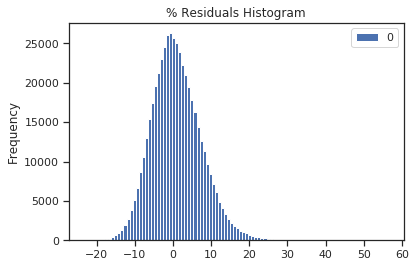

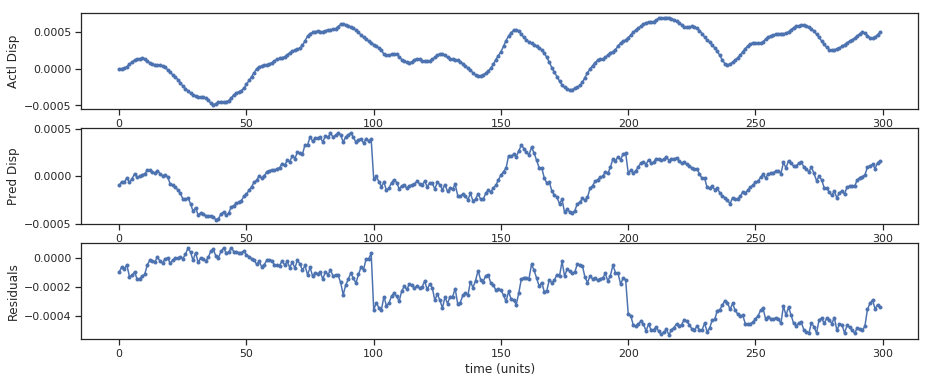

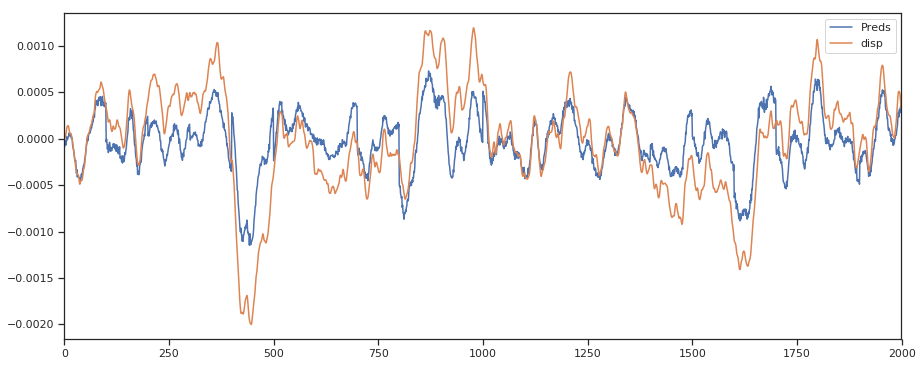

In [16]:
# Data
X_train, X_test, y_train, y_test = train_test_split(noise_input_vals, noise_output_vals, test_size=0.3, random_state=42)

# Run and results
run_and_results(X_train, X_test, y_train, y_test)